In [77]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
from scipy.stats import f

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Pre-processamento'

file_path_raw = base_path / 'dataset_cotton_fruit.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)

[0.79360913 0.89412885 0.94697142 0.97166537 0.98796145 0.99201269
 0.9941883  0.99583757 0.99700547 0.99750741 0.99785709 0.9981647
 0.99839712 0.99858418 0.9987251 ]
Optimal number of components: 5


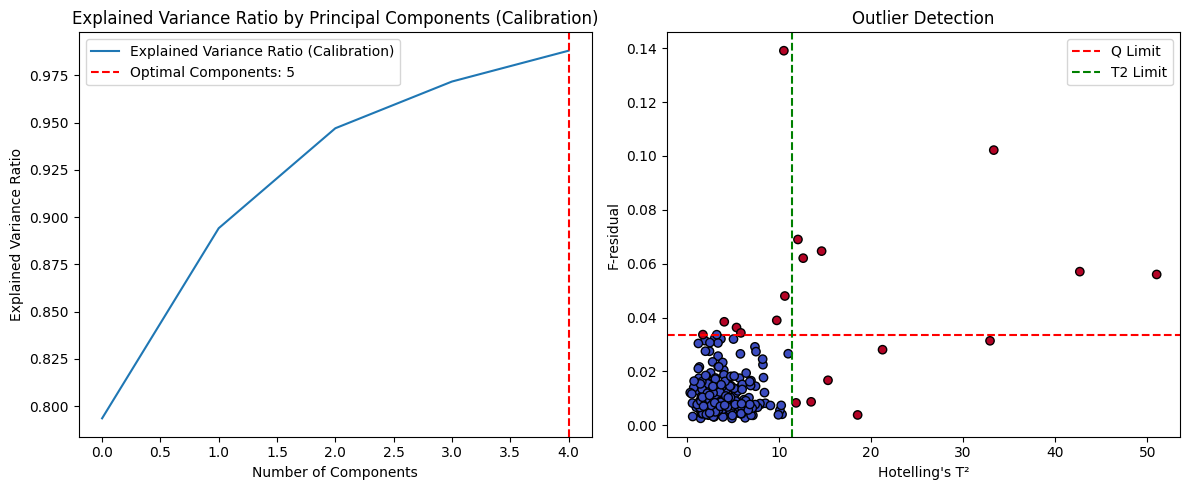

Optimal number of components: 5
Cross-Validation Error: 0.11097197952174377
Outliers detected: 19
Calibration data: (175, 2150)
Validation data: (75, 2150)
Calibration data saved to 'calibration_data.xlsx'
Validation data saved to 'validation_data.xlsx'


c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:685: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


In [76]:
# Função para centralizar os dados
def mean_centering(data):
    return data - np.mean(data, axis=0)

# Função para calcular variância explicada acumulada
def explained_variance(pca):
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    return explained_variance

# Teste de incerteza jackknife
def jackknife_variance(pca, X):
    loo = LeaveOneOut()
    explained_variances = []

    for train_index, test_index in loo.split(X):
        X_train = X[train_index]
        pca.fit(X_train)
        explained_variances.append(explained_variance(pca))

    return np.mean(explained_variances, axis=0), np.std(explained_variances, axis=0)

# Determinar o número ótimo de componentes
def determine_optimal_components(X_centered):
    pca = PCA(n_components=15)
    mean_explained_variance, std_explained_variance = jackknife_variance(pca, X_centered)

    min_diff_index = 0
    
    print(mean_explained_variance)

    for i in range(1, len(mean_explained_variance)):
        diff = mean_explained_variance[i] - mean_explained_variance[i - 1]
        if diff <= 0.009:
            min_diff_index = i - 1  # Armazena o índice anterior
            break
    
    optimal_components = min_diff_index + 1  # Adicionar 1 para obter o número correto de componentes

    return optimal_components, mean_explained_variance, std_explained_variance

# Validar o número ótimo de componentes com Leave-One-Out Cross-Validation
def validate_optimal_components(X, n_components):
    loo = LeaveOneOut()
    errors = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        reconstruction_error = np.linalg.norm(X_test - pca.inverse_transform(X_test_pca))
        errors.append(reconstruction_error)

    return np.mean(errors)

# Detecção de outliers usando Hotelling's T² e F-residual
def detect_outliers(X, pca, alpha=0.05):
    T2 = np.sum((pca.transform(X) ** 2) / pca.explained_variance_, axis=1)
    Q = np.sum((X - pca.inverse_transform(pca.transform(X))) ** 2, axis=1)
    
    T2_limit = (pca.n_samples_ - 1) * pca.n_components / (pca.n_samples_ - pca.n_components) * \
               f.ppf(1 - alpha, pca.n_components, pca.n_samples_ - pca.n_components)

    outliers = (T2 > T2_limit) | (Q > np.percentile(Q, 100 * (1 - alpha)))

    return outliers, T2, Q, T2_limit

# Seleção de amostras usando o método Kennard-Stone
def kennard_stone(data, n_samples):
    distances = np.linalg.norm(data[:, np.newaxis] - data, axis=-1)
    np.fill_diagonal(distances, np.inf)
    selected_samples = [np.argmax(distances.sum(axis=0))]

    for _ in range(1, n_samples):
        dist_to_selected = distances[:, selected_samples].min(axis=1)
        next_sample = np.argmax(dist_to_selected)
        selected_samples.append(next_sample)

    selected_data = pd.DataFrame(data[selected_samples])

    return selected_data

# Função para salvar os dados de calibração e validação
def save_calibration_validation_data(calibration_data, validation_data, calibration_file='calibration_data.xlsx', validation_file='validation_data.xlsx'):
    calibration_data.to_excel(calibration_file, index=False)
    validation_data.to_excel(validation_file, index=False)
    print(f"Calibration data saved to '{calibration_file}'")
    print(f"Validation data saved to '{validation_file}'")

# Função principal
def main(data):
    # Convertendo os dados para um DataFrame
    df_data = pd.DataFrame(data)

    # Centralização dos dados
    data_centered = mean_centering(df_data)

    # Verificação de NaNs
    if np.isnan(data_centered.values).any():
        print("Os dados contêm NaNs. Por favor, limpe os dados antes de prosseguir.")
        return
    
    # Determinação do número ótimo de componentes
    optimal_components, mean_explained_variance, std_explained_variance = determine_optimal_components(data_centered.values)
    print(f"Optimal number of components: {optimal_components}")
    
    # Validação do número ótimo de componentes
    cross_val_error = validate_optimal_components(data_centered.values, optimal_components)
    
    # Aplicação do PCA com o número ótimo de componentes
    pca = PCA(n_components=optimal_components)
    pca.fit(data_centered.values)

    # Detecção de outliers
    outliers, T2, Q, T2_limit = detect_outliers(data_centered.values, pca)
    
    # Cálculo da variância explicada acumulada para calibração
    pca_calibration = PCA(n_components=optimal_components)
    pca_calibration.fit(mean_centering(data_centered.values))
    explained_variances_calibration = explained_variance(pca_calibration)

    # Visualização dos resultados
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(explained_variances_calibration, label='Explained Variance Ratio (Calibration)')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components (Calibration)')
    plt.axvline(optimal_components - 1, color='r', linestyle='--', label=f'Optimal Components: {optimal_components}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(T2, Q, c=outliers, cmap='coolwarm', edgecolor='k')
    plt.axhline(np.percentile(Q, 100 * (1 - 0.05)), color='r', linestyle='--', label='Q Limit')
    plt.axvline(T2_limit, color='g', linestyle='--', label='T2 Limit')
    plt.xlabel("Hotelling's T²")
    plt.ylabel('F-residual')
    plt.title('Outlier Detection')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Optimal number of components: {optimal_components}')
    print(f'Cross-Validation Error: {cross_val_error}')
    print(f'Outliers detected: {np.sum(outliers)}')

    # Seleção de amostras usando o método Kennard-Stone
    total_samples = data.shape[0]
    n_samples_calibration = int(0.7 * total_samples)

    # Seleção de amostras com Kennard-Stone
    selected_data = kennard_stone(data_centered.values, n_samples_calibration)

    # Cálculo do número de amostras de validação
    n_samples_validation = total_samples - n_samples_calibration

    # Criando conjuntos de dados de calibração e validação
    calibration_data = selected_data
    print("Calibration data:", calibration_data.shape)
    validation_data = df_data[~df_data.index.isin(selected_data.index)]
    print("Validation data:", validation_data.shape)
    
    save_calibration_validation_data(calibration_data, validation_data)

    # Verificações de validação
    assert len(calibration_data) == n_samples_calibration, f"Calibration data does not have {n_samples_calibration} samples."
    if len(validation_data) != n_samples_validation:
        raise ValueError(f"Validation data does not have {n_samples_validation} samples. Incorrect selection.")

    # Divisão dos componentes entre calibração e validação
    n_calib_components = int(0.7 * optimal_components)
    n_valid_components = optimal_components - n_calib_components

    # Garantir que o número de componentes para validação seja pelo menos 1
    if n_valid_components < 1:
        n_valid_components = 1
        n_calib_components = optimal_components - n_valid_components

    pca_calibration = PCA(n_components=n_calib_components)
    pca_calibration.fit(mean_centering(calibration_data.values))

    pca_validation = PCA(n_components=n_valid_components)
    pca_validation.fit(mean_centering(validation_data.values))

# Carregue seus dados aqui
X_raw = df_raw.iloc[:, 7:2157].values

main(X_raw)
